### Import Libraries

In [3]:
import subprocess
import platform
import re
import statistics
import matplotlib.pyplot as plt
import pandas as pd

In [21]:
def ping_server(server, count=3):
    """Ping a server and return average latency, std dev, and packet size."""
    is_windows = platform.system().lower() == "windows"
    param = "-n" if is_windows else "-c"

    try:
        result = subprocess.run(
            ["ping", param, str(count), server],
            capture_output=True, text=True
        )
        output = result.stdout

        print(f"Ping output for {server}:\n{output}")

        if is_windows:
            # Extract individual times from reply lines (Windows output)
            time_matches = re.findall(r"(?:temps|time)[=<]?\s?(\d+)\s?ms", output)
            times = [float(t) for t in time_matches]

            if times:
                avg_latency = statistics.mean(times)
                std_latency = statistics.stdev(times) if len(times) > 1 else 0.0
            else:
                return None, None, None

        else:
            # On Linux, parse summary line 'rtt min/avg/max/mdev = ...'
            match = re.search(
                r"rtt min/avg/max/mdev = ([\d.]+)/([\d.]+)/([\d.]+)/([\d.]+) ms",
                output
            )
            if match:
                avg_latency = float(match.group(2))
                std_latency = float(match.group(4))
            else:
                return None, None, None

        # Packet size (from one of the reply lines)
        match_size = re.search(r"(\d+)\s*(?:octets|bytes)\s+from", output)
        packet_size = int(match_size.group(1)) if match_size else None

        return avg_latency, std_latency, packet_size

    except subprocess.SubprocessError as e:
        print(f"Ping failed: {e}")
        return None, None, None


Ping the different mail servers to test the response time

In [ ]:
# List of mail servers to test
mail_servers = {
    "Gmail": "mail.google.com",
    "Outlook": "outlook.office.com",
    "ProtonMail": "mail.proton.me"
}

# Run the test
for name, server in mail_servers.items():
    avg, std, packet_size = ping_server(server)
    if avg is not None:
        print(f"{name} ({server}): Moyenne = {avg} ms, Écart-type = {std:.2f} ms, Taille du paquet = {packet_size} octets")
    else:
        print(f"Impossible de ping {name} ({server})")


Gmail (mail.google.com): Moyenne = 15.2 ms, Écart-type = 2.40 ms, Taille du paquet = 32 octets
Outlook (outlook.office.com): Moyenne = 15.79 ms, Écart-type = 1.98 ms, Taille du paquet = 32 octets
ProtonMail (mail.proton.me): Moyenne = 25.24 ms, Écart-type = 13.53 ms, Taille du paquet = 32 octets


Also test localhost for to account for the self-hosted solution response time

In [33]:
avg, std, packet_size = ping_server('127.0.0.1')
if avg is not None:
    print(f"MySolution (127.0.0.1): Moyenne = {avg} ms, Écart-type = {std:.2f} ms, Taille du paquet {packet_size} octets")

MySolution (127.0.0.1): Moyenne = 1 ms, Écart-type = 0.00 ms, Taille du paquet 32 octets


Ping the ULB server from Home to get `remote` latency

In [ ]:
import requests
import time

def https_latency(url):
    start = time.time()
    try:
        response = requests.get(url, timeout=5, verify=False)  # Disable SSL verification for localhost
        response.raise_for_status()
        end = time.time()
        latency_ms = (end - start) * 1000  # convert to milliseconds
        return latency_ms
    except requests.RequestException as e:
        print(f"Request failed: {e}")
        return None

url = "https://localhost"
times = []

while len(times) < 100:
    latency = https_latency(url)
    if latency is not None:
        times.append(latency)
        print(f"{len(times)/100:.0%} completed, current latency: {statistics.mean(times):.2f} ms") if len(times) % 10 == 0 else None
    else:
        print("Failed to measure latency, retrying...")

print(f"Average latency over 10 measurements: {statistics.mean(times):.2f} ms")


In [36]:
avg, std, packet_size = ping_server('google.com', count=3)
if avg is not None:
    print(f"MySolution (Remote Emulation): Mean = {avg} ms, Std = {std:.2f} ms, Packet Size : {packet_size} Bytes")

Ping output for google.com:
PING google.com (2a00:1450:400c:c06::65) 56 data bytes
64 bytes from wb-in-f101.1e100.net (2a00:1450:400c:c06::65): icmp_seq=1 ttl=109 time=19.2 ms
64 bytes from wb-in-f101.1e100.net (2a00:1450:400c:c06::65): icmp_seq=2 ttl=109 time=24.9 ms
64 bytes from wb-in-f101.1e100.net (2a00:1450:400c:c06::65): icmp_seq=3 ttl=109 time=11.8 ms

--- google.com ping statistics ---
3 packets transmitted, 3 received, 0% packet loss, time 2002ms
rtt min/avg/max/mdev = 11.758/18.644/24.935/5.395 ms

MySolution (Remote Emulation): Mean = 18.644 ms, Std = 5.39 ms, Packet Size : 64 Bytes


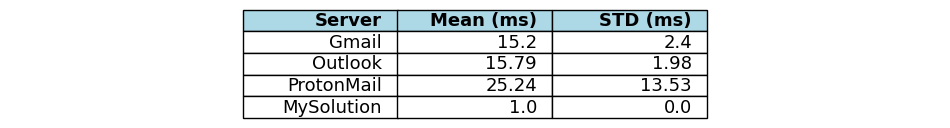

In [45]:
# Create a dataframe with the results
df_results = pd.DataFrame({
    'Server': ['Gmail', 'Outlook', 'ProtonMail', 'MySolution'],
    'Mean (ms)': [15.2, 15.79, 25.24, 1],
    'STD (ms)': [2.40, 1.98, 13.53, 0]

})

# Create a figure and a single subplot with adjusted size
fig, ax = plt.subplots(figsize=(12, 1))

# Hide axes
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Create the table with adjusted cell colors
table = ax.table(cellText=df_results.values, colLabels=df_results.columns, cellLoc='center', loc='center', 
                 colColours=['lightblue']*df_results.shape[1],)

# Make the column headers and index bold
for (row, col), cell in table.get_celld().items():
    if row == 0 :
        cell.set_text_props(weight='bold')
    cell.get_text().set_ha('right')
table.auto_set_font_size(False)
table.set_fontsize(13)
table.scale(.5, 1.3)

# Display the plot
plt.show()
